In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("module.jl")
using .PhasorNetworks

In [3]:
using Plots

In [4]:
using LinearAlgebra: triu, diagm, diag

In [5]:
using Statistics: std, median

In [6]:
using QuadGK

# Construct a random graph

In [7]:
function generate_er_graph(n::Int, p::Real, self_loops::Bool = false)
    adj = rand(Float64, (n, n)) .< p
    #make undirected
    adj = triu(adj)
    adj =  (adj .+ adj') .> 0

    if !self_loops
        #remove self-loops
        for i in 1:n
            adj[i,i] = 0
        end
    end

    return adj
end

generate_er_graph (generic function with 2 methods)

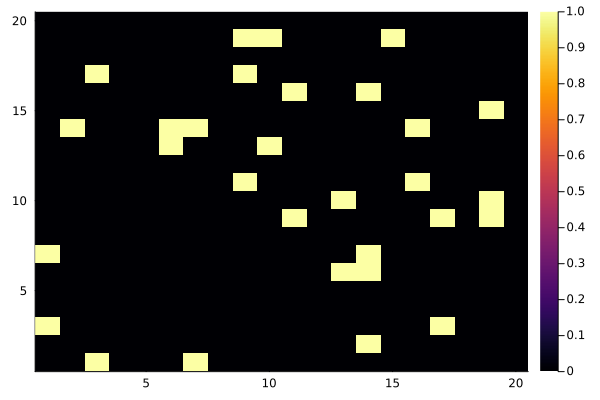

In [8]:
g1 = generate_er_graph(20, 0.1)
heatmap(g1)

# Embed it into an HD vector

In [9]:
function define_node_symbols(graph::AbstractMatrix, nd::Int)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)

    #create vectors representing the nodes
    node_values = random_symbols((n, nd))
    return node_values
end

define_node_symbols (generic function with 1 method)

In [10]:
nv1 = define_node_symbols(g1, 1024);

In [11]:
size(nv1)

(20, 1024)

In [12]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix, nd::Int)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)

    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = zeros(Float64, n_edges, nd)

    #iterate through the edges
    for (i, edge) in enumerate(edges)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = node_values[tx,:]
        rx_symbol = node_values[rx,:]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = PhasorNetworks.bind(tx_symbol, rx_symbol)
        edge_values[i,:] = edge_symbol
    end

    #combine the edges in the graph to the single embedding via bundling
    graph_embedding = bundle(edge_values, dims=1)
    return graph_embedding
end

graph_to_vector (generic function with 1 method)

In [13]:
gv1 = graph_to_vector(g1, nv1, 1024)

1×1024 Matrix{Float64}:
 -0.97132  0.236372  -0.187894  -0.970468  …  0.870419  0.533233  -0.556289

In [14]:
sa = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [15]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix, nd::Int, spk_args::SpikingArgs; repeats::Int=3)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    
    #slice each node symbol into a spike train
    train_values = [phase_to_train(reshape(node, (1,:)), spk_args, repeats=repeats) for node in eachslice(node_values, dims=1)]
    tspan = (0.0, repeats * 1.0)
    
    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = []

    #iterate through the edges
    function edge_to_train(edge)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = train_values[tx]
        rx_symbol = train_values[rx]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = PhasorNetworks.bind(tx_symbol, rx_symbol, spk_args=spk_args, tspan=tspan)
        return edge_symbol
    end

    edge_values = map(edge_to_train, edges)
    #combine the edges in the graph to the single embedding via bundling
    combined = vcat_trains(edge_values)
    graph_embedding = bundle(combined, dims=1, spk_args=spk_args, tspan=tspan)
    return train_values, graph_embedding, tspan
end

graph_to_vector (generic function with 2 methods)

In [16]:
nvt1, gvt1, tspan = graph_to_vector(g1, nv1, 1024, sa, repeats=5)

(SpikeTrain[Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes.], Spike Train: (1, 1024) with 5943 spikes., (0.0, 5.0))

In [17]:
nvt1[2]

Spike Train: (1, 1024) with 5120 spikes.

In [18]:
gvt1

Spike Train: (1, 1024) with 5943 spikes.

In [19]:
gv1

1×1024 Matrix{Float64}:
 -0.97132  0.236372  -0.187894  -0.970468  …  0.870419  0.533233  -0.556289

In [20]:
phases = train_to_phase(gvt1, sa);

In [21]:
ss = similarity(gv1, zero_nans(phases[2,1:1,:]), dim=1)

1×1024 Matrix{Float64}:
 -0.995944  0.993479  0.994917  -0.995699  …  0.999547  0.994555  0.990586

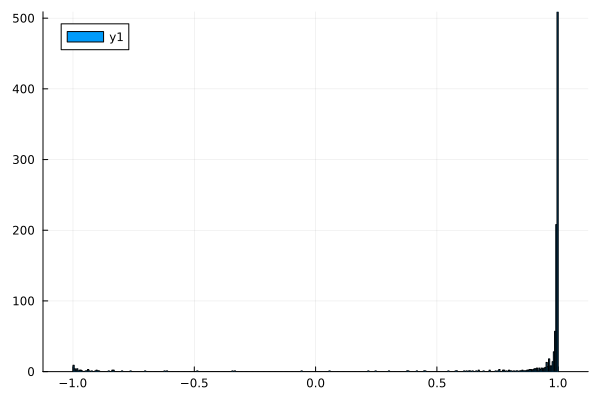

In [22]:
histogram(ss |> vec)

In [23]:
median(ss)

0.9949712339367769

# Use similarity to reconstruct the graph

In [24]:
function query_edges(graph::AbstractMatrix, nodes::AbstractMatrix)
    n = size(nodes, 1)
    nd = size(graph, 2)

    adj_rec = zeros(Float64, n, n)
    for (i,node) in enumerate(eachslice(nodes, dims=1))
        #add a dimension for consistency
        node = reshape(node, (1, :))
        query = unbind(graph, node)
        s = similarity_outer(query, nodes, dims=1) |> vec
        adj_rec[i,:] = s
    end

    return adj_rec
end

query_edges (generic function with 1 method)

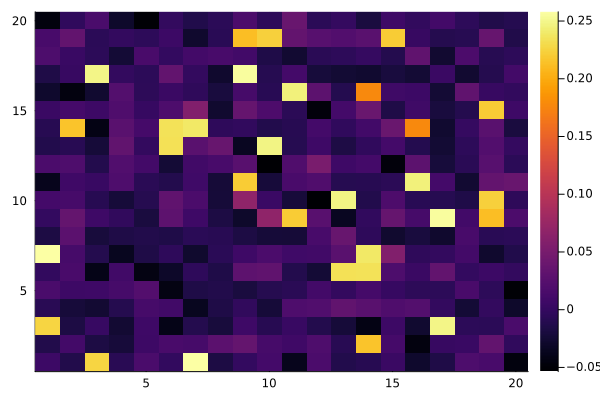

In [25]:
rec1 = query_edges(gv1, nv1)
heatmap(rec1)

In [26]:
qst = unbind(gv1, nv1[1:1,:])

1×1024 Matrix{Float64}:
 0.923207  -0.861808  -0.0847524  -0.934391  …  -0.478061  0.732573  0.712388

In [27]:
function query_edges(graph::SpikeTrain, nodes::Vector{<:SpikeTrain}, spk_args::SpikingArgs, tspan::Tuple{<:Real, <:Real})


    all_nodes = vcat_trains(nodes)
    
    function query_edge(node)
        query = unbind(graph, node, tspan=tspan, spk_args=spk_args)
        s = similarity_outer(query, all_nodes, dims=1, reduce_dim=2, spk_args=sa, tspan=tspan)
        return s
    end
    
    return map(query_edge, nodes)

    return adj_rec
end

query_edges (generic function with 2 methods)

In [28]:
maximum(getfield.(nvt1, :offset))

0.0

In [29]:
r = query_edges(gvt1, nvt1, sa, tspan)

20-element Vector{Matrix{Matrix{Float64}}}:
 [[-1.0 -1.0 … 0.03320740207703025 0.03327287579662716] [-1.0 -1.0 … -0.02058453595375844 -0.02053739334024586] … [-1.0 -1.0 … -0.0007582391816179051 -0.0007501491922479796] [-1.0 -1.0 … -0.044068062893824575 -0.04419575127173479]]
 [[-1.0 -1.0 … -0.020207419279869937 -0.020273349760551652] [-1.0 -1.0 … 0.014763625820541375 0.015012310467946948] … [-1.0 -1.0 … 0.019357713789309672 0.01906941715787781] [-1.0 -1.0 … -0.02567596672576611 -0.02590037939429274]]
 [[-1.0 -1.0 … 0.19630322870100977 0.19665912759025792] [-1.0 -1.0 … -0.01218233581434534 -0.012455031852856683] … [-1.0 -1.0 … -0.01185067948646766 -0.011851111695198036] [-1.0 -1.0 … 0.018682371554465928 0.01855297874555372]]
 [[-1.0 -1.0 … -0.01440286065079635 -0.014026390089511] [-1.0 -1.0 … -0.020295929013364373 -0.020647076824620837] … [-1.0 -1.0 … -0.001138429893470677 -0.0007673131029338025] [-1.0 -1.0 … -0.022140192569186236 -0.021969605787221524]]
 [[-1.0 -1.0 … 0.013284464310340

In [30]:
sop = stack(map(x -> last.(x), r))

1×20×20 Array{Float64, 3}:
[:, :, 1] =
 0.0332729  -0.0205374  0.197889  …  0.0298528  -0.000750149  -0.0441958

[:, :, 2] =
 -0.0202733  0.0150123  -0.0148027  …  0.00232167  0.0190694  -0.0259004

[:, :, 3] =
 0.196659  -0.012455  0.019776  …  0.0138104  -0.0118511  0.018553

;;; … 

[:, :, 18] =
 0.0269339  2.93204e-5  0.00950921  …  0.00308827  -0.0208846  -0.00637847

[:, :, 19] =
 -0.000467363  0.0244087  -0.00660967  …  -0.0166645  0.0581975  -0.00954705

[:, :, 20] =
 -0.0467022  -0.0266703  0.0116134  -0.02195  …  -0.00977539  -0.0135999

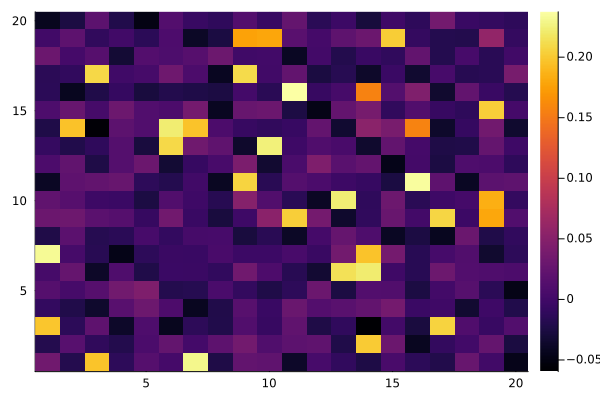

In [31]:
heatmap(sop[1,:,:])

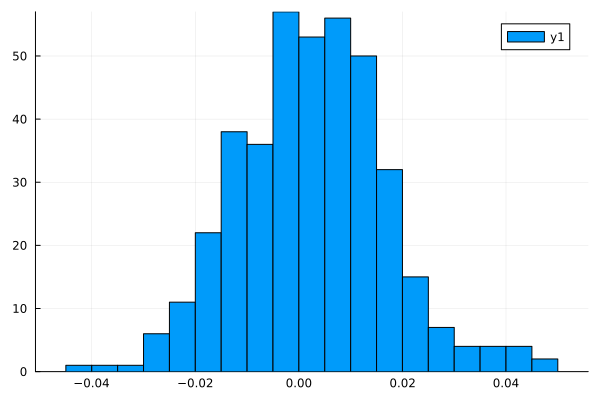

In [34]:
histogram((rec1 .- sop[1,:,:])|> vec)

# Reconstruct the graph with oscillator operations

In [ ]:
function query_edges_osc(graph::AbstractMatrix, nodes::AbstractMatrix)
    n = size(nodes, 1)
    nd = size(graph, 2)

    adj_rec = zeros(Float64, n, n)
    for (i,node) in enumerate(eachslice(nodes, dims=1))
        #add a dimension for consistency
        node = reshape(node, (1, :))
        query = unbind(graph, node)
        s = similarity_outer(query, nodes, dims=1) |> vec
        adj_rec[i,:] = s
    end

    return adj_rec
end

query_edges (generic function with 1 method)

# Determine the quality of the reconstruction (AUROC)

In [16]:
tpr, fpr = tpr_fpr(vec(rec1), vec(g1))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

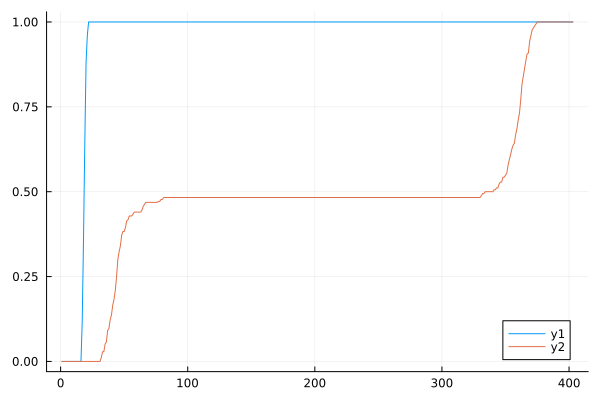

In [25]:
plot(tpr)
plot!(fpr)

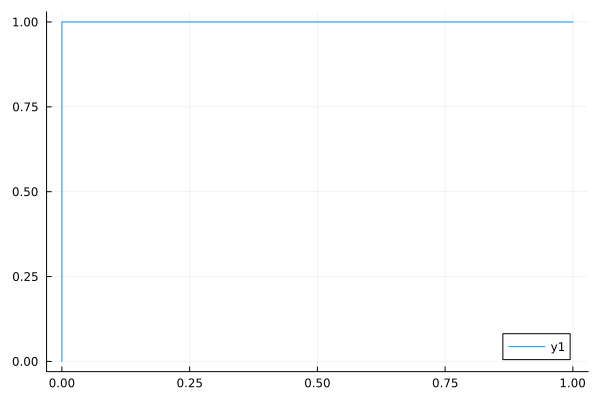

In [19]:
plot(fpr, tpr)

In [23]:
roc = interpolate_roc((tpr, fpr));

In [24]:
quadgk(x -> roc(x), 0.0, 1.0)

(1.0, 0.0)

# Run an experiment over multiple graphs